In [1]:
import numpy  as np
import pandas as pd
import time
from datetime import datetime
import joblib
import os
from tabulate                      import tabulate
from sklearn.decomposition         import PCA
from sklearn.model_selection       import GridSearchCV
from sklearn.svm                   import SVC
from sklearn.svm                   import LinearSVC
from lightgbm                      import LGBMClassifier
from sklearn.preprocessing         import StandardScaler
from sklearn.model_selection       import train_test_split
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.dummy                 import DummyClassifier
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.ensemble              import HistGradientBoostingClassifier
from sklearn.ensemble              import GradientBoostingClassifier
from sklearn.ensemble              import BaggingClassifier 
from sklearn.ensemble              import ExtraTreesClassifier
from sklearn.ensemble              import ExtraTreesRegressor
from sklearn.model_selection       import cross_validate
from sklearn.model_selection       import cross_val_score
from sklearn.metrics               import f1_score
from sklearn.metrics               import r2_score
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import classification_report
from sklearn.metrics               import recall_score
from sklearn.metrics               import fbeta_score
from sklearn.metrics               import precision_score
from sklearn.metrics               import roc_auc_score
from sklearn.feature_selection     import f_regression
from sklearn.ensemble              import RandomForestClassifier
import json
from matplotlib import pyplot as plt
import seaborn as sns
import shap

rep_base  = "../"
rep_src   = rep_base + "/data/raw/"        # Fichiers téléchargés avant traitements
rep_inter = rep_base + "/data/inter/"      # Des fichiers intermédiaires sont utilisés
rep_dst   = rep_base + "/data/processed/"  # Fichiers utilsés par la modélisation
rep_ref   = rep_base + "/references/"      # Informations sur les fichiers format, noms de variables...
rep_fig   = rep_base + "/reports/figures/" # Graphes pour les rapports
rep_mdl   = rep_base + "/models/"          # Modèles entraînés


# Quelques auxiliaires 
## printlog()
Cette fonction affiche les messages à l'écran et les ajoute à une chaîne de caractères nomée logres. Elle permet d'enregistrer les message dans un fichier avec les résultats d'entraînement.
## format_duree()
Cette fonction convertit une durée en une chaîne de caractères contenant heures, minutes et secondes.

In [3]:
logres = ""
def printlog(msg=""):
    global logres
    logres += f"{msg}\n"
    print (msg)
    return
    
def format_duree(seconds_f):
    # Conversion en heures, minutes et secondes
    seconds = int(seconds_f)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    
    # Formatage conditionnel en fonction de la durée
    if hours > 0:
        return f"{hours} h {minutes}min"
    elif minutes > 0:
        return f"{minutes} min {secs} s"
    else:
        return f"{secs} s"


# Lecture des données avec descriptions et séparation des variables explicatives et cibles
Cette cellule lit le jeu de données et sépare les variables explicatives et la variable cible. De plus, lors du développement et de la mise au point de la cellule d'entraînement elle réalise un sous-échantillonage avec df.sample() pour réduire les temps d'entraînement. Il est ainsi possible de faire un modification de code et d'en voir le résultat après quelques minutes au lieu de d'une heure. Nous constatons une réduction des scores; avec seulement 5000 observations les scores restent suffisants pour les essais; la valeur de random_state n'a alors aucune importance.

In [5]:
# Lecture du jeu de données
df = pd.read_csv(rep_dst + '/' + "data.csv", sep = '\t', index_col = None)

# Pour essais préalables et mise au point
# Avec 5000, voire 2500 observation le temps d'entraînement est très faible,
# de l'ordre de deux minutes. Cela permet de mettre au point le notebook.
# df = df.sample(5000)

# et séparation des variables explicatives et de la variable cible

X = df.drop(['grav_grave'], axis = 1)
feature_names = X.columns

y= df.grav_grave

# Lecture de la description des variables, avec leurs libellés
with open(rep_ref + "/desc_vars.json", 'r', encoding='utf-8') as fichier:
    desc_vars = json.load(fichier)

In [6]:
# Pour contrôle
print (f"Dimension du jeu de données : {df.shape[0]} x {df.shape[1]}")

Dimension du jeu de données : 177644 x 266


# Réduction de dimension avec la PCA
Le jeu de données contient environ 260 variables explicatives, ce nombre est très important, nous décidons alors d'appliquer une PCA. 
Après avoir appliqué la PCA nous normalisons le jeu de données de dimension réduite.
Le graphique avec les variances individuelle et cumulée en fonction du nombre de composantes nous aide à choisir le nombre de composantes ede la PCA.
Nous choisissons 100 composantes afin d'avoir au moins 90% de variance expliquée et  de préserver les performances des modèles. Il conviendrait d'essayer ultérieurement des nombres de composantes plus faibles pour le modèle retennu en surveillant la métrique.

Varience expliquée : 0.9220201663041253


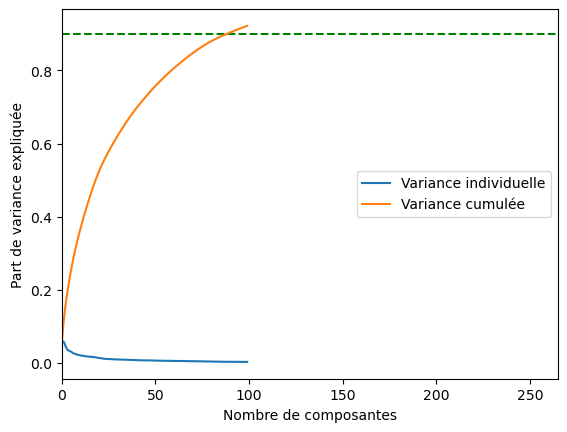

In [8]:
# Réduction de dimension
pca = PCA(n_components = 100)
pca.fit(X)

plt.figure()
plt.xlim(0,X.shape[1])
plt.plot(pca.explained_variance_ratio_, label = "Variance individuelle");
plt.xlabel('Nombre de composantes')
plt.ylabel('Part de variance expliquée')
plt.axhline(y = 0.90, color ='g', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum(), label = "Variance cumulée");
plt.legend (loc='center right')
print (f"Varience expliquée : {pca.explained_variance_ratio_.cumsum()[100-1]}")


X_pca = pca.transform(X)
# standardisation
scaler = StandardScaler()
X_pca_scale = scaler.fit_transform(X_pca)

In [9]:
# Pour vérification 

print (f"Dimensions du jeu de données après PCA : {X_pca_scale.shape[0]} x {X_pca_scale.shape[1]}")


Dimensions du jeu de données après PCA : 177644 x 100


# Séparation du jeu de données et de tests
Nous entrainons nos modèles avec 80% du jeu de données et faisons les test avec les 20% restants.
Le paramètre random_state est fixé à 1234 pour la reproductibilité des tests.

In [11]:
# Séparation du jeu de données d'entraînement et de tests
X_train, X_test, y_train, y_test = train_test_split(X_pca_scale, y, test_size = .20, random_state = 1234)

In [61]:

joblib.dump(pca,    rep_mdl + "pca_ml.mdl")
joblib.dump(scaler, rep_mdl + "scaler_ml.mdl")

['..//models/scaler_ml.mdl']

# Essais et entraînement de modèles
Nous entraînons les modèles que nous avons découverts lors des cours et un modèle proposé par lazypredict
avec pour certains plusieurs hyper paramètres. Les modèles sont les suivants :
Classification à support de vecteurs
 - Régression logistique
 - Hist Gradient Boosting Classifier
 - LGBMClassifier
 - Arbre de décision
 - Extra Trees Classifier
 - Bagging Classifier
 - Plus proches voisins
 - Forêt aléatoire
 - Gradient Boosting Classifier
 - Dummy Classifier, pour comparaison uniquement.

*Important:* À cause de temps d'entraînement trop longs les listes de paramètres à essayer avec GridSearchCV (param_grid)
sont mises en commentaires.

## Utilisation de GridSearchCV
Nous utilisons GridSearch CV pour entrîner le modèles et, pour certains, trouver les meilleurs paramètres. 

## Critères de choix du modèle et métriques utilisées
Nous décidons de chercher les circonstances qui qui provoquent les cas graves. Avant d'arréter ce choix nous avons affiché plusieurs métriques d'évaluation des modèles.

### Métriques essayées / affichées
Nous essayons les métriques suivantes :
- Scores sur le jeu d'entraînement et le jeu de test ;
- f1 ;
- AUC ;
- Précision ;
- Rappel ;
- FBéta, avec Béta = 2 ;
- R2
    
### Métrique retenue
Finalement nous choisissons le score sur jeux de test élevé et un taux de faux négatifs minimal.
Nous privilégiions un taux de faux négatifs minimal pour mieux "voir les conditions" qui provoquent des accident graves

## Choix de codage
Codage permettant des modif très faciles et rapides
Affichages détaillés pour le contrôle, la mise au point, les essais et la compréhension des principes sous-jacents des modèles et de leurs performances
Utilisation d'un dictionnaire pour la liste des modèles
Utilisation d'un DataFrame pour stocker les scores et performances des modèles
Affichages synthétiques et essentiels possibles dans les cellules suivantes avec le tableau de résulats
Affichage et enregistrement dans un fichier des résultats pour exploitation ultérieure et comparaisons

## Affichages
Les affichages de cette cellule sont destinés à vérifier le bon déroulement des calculs.
Les résultats plus lisibles avec les tableaux et graphes des cellules suivantes.


In [14]:
modeles = {
# Les essais été faits avec des paramètres variés, cependant
# L'entraînement du modèle SVC est très long. les paramètres sont essayés
# avec un jeu de donnée de taille réduite, puis l'entraînement est fait 
# avec les meilleurs paramètres. C'est la raison de la mise en commentaires
# des choix de paramètres.
    
"SVC" : {
    "prmsgscv" : {#"gamma" : ["scale", "auto"]
                  #"kernel" : ["linear", 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  },
    "prmfixes" : {},
    "pred"     : None,
    "perf"     : [],
    "nom"      : "SVC",
    "libelle"  : "Classification à support de vecteurs",
    "classe"   : "sklearn.svm.SVC",
    "instance" : SVC(),
    "grid"     : None
},
    
"LR" : {
    "prmsgscv" : {'solver' : ['liblinear', 'lbfgs'],
                 # 'C'      : [10**(i) for i in range(-4, 3)]},
                  'C'      : [0.003, 0.005, 0.01, 0.02, 0.04]},
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "LogisticRegression",
    "libelle"  : "Régression logistique",
    "classe"   : "sklearn.xxx",
    "instance" : LogisticRegression(max_iter = 10000),
    "grid"     : None
},

"HGB" : {
    "prmsgscv" : {#"min_samples_leaf" : [3, 4, 5, 7, 10, 14, 20, 28]
                 "max_leaf_nodes" : [None, 15, 31, 63 ],
                 "l2_regularization" : [0.001, 0.01, 0.1, 1, 10],
                 
                 },
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "HistGradientBoostingClassifier",
    "libelle"  : "Hist Gradient Boosting Classifier",
    "classe"   : "sklearn.neighbors.HistGradientBoostingClassifier",
    "instance" : HistGradientBoostingClassifier(random_state = 421),
    "grid"     : None
},

"LGBM" : {
    "prmsgscv" : { # rf provoque des erreurs
                  "boosting_type" : ["gbdt", "dart", "goss"],
                  #"num_leaves"    : [15,31,63],
                  #"learning_rate" : [0.05, 0.1, 0.2],
                  #"n_estimators"  : [50, 100, 200]
                 },
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "LGBMClassifier",
    "libelle"  : "LGBMClassifier",
    "classe"   : "sklearn.",
    "instance" : LGBMClassifier(verbosity=-1, random_state = 421),
    "grid"     : None
},

"DT" : {
    "prmsgscv" : {"criterion" : ["gini", "entropy", "log_loss"],
                  "splitter" : ["best", "random"]},
                  
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "DecisionTreeClassifier",
    "libelle"  : "Arbre de décision",
    "classe"   : "sklearn.tree.DecisionTreeClassifier",
    "instance" : DecisionTreeClassifier(random_state = 123), 
    "grid"     : None
},

"ET" : {
    "prmsgscv" : {},
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "ExtraTreesClassifier",
    "libelle"  : "Extra Trees Classifier",
    "classe"   : "sklearn.ensemble.ExtraTreesClassifier",
    "instance" : ExtraTreesClassifier(),
    "grid"     : None
},

"BAG" : {
    "prmsgscv" : {},
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "BaggingClassifier",
    "libelle"  : "Bagging Classifier",
    "classe"   : "sklearn.neighbors.BaggingClassifier",
    "instance" : BaggingClassifier(),
    "grid"     : None
},

"KNN" : {
    "prmsgscv" : {#"n_neighbors" : [2, 3, 5, 8, 10, 12, 15],
                  "metric" : ['minkowski', 'manhattan', 'chebyshev']},
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "KNeighborsClassifier",
    "libelle"  : "Plus proches voisins",
    "classe"   : "sklearn.neighbors.KNeighborsClassifier",
    "instance" : KNeighborsClassifier(),
    "grid"     : None
},

"RF" : {
    "prmsgscv" : {#"n_estimators" : [50,100,200],
                  #"max_depth" : [3,5,10,20,40]
                 },
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "RandomForestClassifier",
    "libelle"  : "Forêt aléatoire",
    "classe"   : "sklearn.neighbors.RandomForestClassifier",
    "instance" : RandomForestClassifier(random_state =421), 
    "grid"     : None
},

"GB" : {
    "prmsgscv" : {"loss" : ["log_loss", "exponential"],
                  #"n_estimators" : [200, 400],
                  "criterion" : ["friedman_mse", "squared_error"],
                  #"min_samples_leaf" : [1,2,4],
                  #"max_features" : [1, 2, 4, 8, 16, 32, 64 , 128]
                  #"max_features" : [ 4, 6, 8, 12, 16, 20, 32 ]
                 },
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "GradientBoostingClassifier",
    "libelle"  : "Gradient Boosting Classifier",
    "classe"   : "sklearn.neighbors.GradientBoostingClassifier",
    "instance" : GradientBoostingClassifier(random_state = 421),
    "grid"     : None
},

# Je n'ai pu m'en empêcher, j'ai mis le classificateur bidon
# Je l'ai fait pour voir et le comparer aux autres modèles.
"BIDON" : {
    "prmsgscv" : {},
    "prmfixes" : {},
    "perf"     : {},
    "nom"      : "DummyClassifier",
    "libelle"  : "Dummy Classifier",
    "classe"   : "sklearn.dummy.DummyClassifier",
    "instance" : DummyClassifier(random_state = 421, strategy = "uniform"),
    "grid"     : None
}

}

###########################################################################
# Initialisations : variables, comptes-rendus, tables...
###########################################################################

# Tableau des performances
tbl_perf = pd.DataFrame({"Modele":[], "libelle":[],
                         "duree_GSCV": [],"duree_GSCV_str": [],
                         "score_ent" : [],"score_test":[],
                         "score_f1_0":[], "score_f1_1":[],
                         "score_auc":[],
                         "score_precision":[],
                         "score_recall_0":[], "score_recall_1":[],
                         "score_fbeta_b2":[],
                          # Nbres vrais/faux positifs/négatifs et pourcentages
                         "tn":[], "tnpc":[], "fp":[], "fppc":[],
                         "fn":[], "fnpc":[], "tp":[], "tppc":[],
                         "taille_mdl":[] # Taille du modèle à enregistrer (octets)
                         })
tbl_perf.set_index("Modele")

# logres est une chaîne de caractères contenant les messages destinés
# à l'affichage sur le notebook et l'enregistrement dans un fichier texte.
logres = "" # Effacement des messages, en cas de ré-exécution de la cellule
printlog(datetime.now())

nb_tot = int(X_test.shape[0] + X_train.shape[0])  # Nbre total d'observations
nb_ent = int(X_train.shape[0])                    # Nbre d'observations pour les entrainements
nb_test = int(X_test.shape[0])                    # Nbre d'observations pour les tests

nb_tot_true = int(y_test.sum() + y_train.sum())   # Nbre total d'observation 'graves'
nb_ent_true = int(y_train.sum())                  # Nbre d'observation 'graves' pour les entrainements
nb_test_true = int(y_test.sum())                  # Nbre d'observation 'graves' pour les tests

nb_tot_false  = nb_tot  - nb_tot_true             # Nbre total d'observation 'non graves'
nb_ent_false  = nb_ent  - nb_ent_true             # Nbre d'observation 'non graves' pour les entrainements
nb_test_false = nb_test - nb_test_true            # Nbre d'observation 'non graves' pour les tests

#
# Affichages de nombre d'observations et modalités de la cible.
# Cet affichage sert principalement à la mise au point du notebook.
#
printlog (f" Tailles           | Total  |  graves (True)   | Non graves (False)")
printlog (f"                   |        | nombre | prop    | nombre |  prop")          
printlog (f"Jeu d'entraînement | {nb_ent:6d} | {nb_ent_true:6d} | {100.*nb_ent_true/nb_ent:6.2f}% | {nb_ent_false:6d} | {100.*nb_ent_false/nb_ent:6.2f}%")
printlog (f"Jeu de test        | {nb_test:6d} | {nb_test_true:6d} | {100.*nb_test_true/nb_test:6.2f}% | {nb_test_false:6d} | {100.*nb_test_false/nb_test:6.2f}%")
printlog (f"Total              | {nb_tot:6d} | {nb_tot_true:6d} | {100.*nb_tot_true/nb_tot:6.2f}% | {nb_tot_false:6d} | {100.*nb_tot_false/nb_tot:6.2f}%")
printlog ()
printlog (f"Nombre de variables explicatives (après PCA) : {X_train.shape[1]:6d}")

ttot1 = time.time()
idx_modele=1 # Numéro du modèle en cours, pour l'affichage uniquement

###########################################################################
# Boucle pour chaque modèle
###########################################################################

for k, m in modeles.items():
    perf = {}
    printlog ()
    printlog (f"-----  {m['libelle']:20s}  [{idx_modele:2d}/{len(modeles):2d}]  -----")
    printlog ("")
    idx_modele += 1
    model = m["instance"]
    params = m["prmsgscv"]
    printlog (f"Paramètres essayés : ")
    for prm, val in params.items():
        printlog (f"     {prm:15s} : {val}")
    printlog ()
    printlog (model)

    ###########################################################################
    # Essais avec GridSearchCV et rech., le cas échéant, meilleurs paramètres
    ###########################################################################

    printlog ("Entraînement avec GridSearchCV : Recherche des meilleurs paramètres")

    t1 = time.time()

    # TODO : mettre la métrique retenue pour la sélection du meilleur modèle
    grille_clf = GridSearchCV(model, param_grid = params, cv = 5, n_jobs = -1)
    grille = grille_clf.fit (X_train, y_train)

    t2 = time.time()

    printlog ()
    printlog ("Paramètres retenus :")
    for it in grille.best_params_.items():
        printlog (f"  {it[0]:20s} : {it[1]}")
    printlog ()

    # Récupération du (meilleur) modèle
    model = grille_clf.best_estimator_
    modeles[k]["model"] = model
    modeles[k]["grille_clf"] = grille_clf

    ###########################################################################
    # Prédiction avec le modèle sélectionné
    ###########################################################################

    printlog ("Prédiction :")
    y_pred = model.predict (X_test)
    t = time.time()
    
    ###########################################################################
    # Calculs des scores, métriques et autres valeurs
    ###########################################################################

    # Le temps d'entraînement d'un modèle avec les meilleurs paramètres n'est
    # pas connu. Le temps retennu est le temps d'entraînement d'un modèle
    # ou de plusieurs modèles avec paramètres différents.
    # Il est toutefois affiché pour information.
    duree_GSCV = grille_clf.refit_time_       # temps d'entraînement du meilleur modèle
    duree_GSCV_str = format_duree(duree_GSCV) # le même plus lisible : h m s
    score_ent = model.score(X_train, y_train)
    score_test = model.score(X_test,  y_test)
    score_f1_0, score_f1_1 = f1_score(y_test, y_pred, average = None)
    score_auc = roc_auc_score(y_test, y_pred, average = None)
    score_precision = precision_score(y_test, y_pred, average = 'macro')
    score_recall_0, score_recall_1 = recall_score(y_test, y_pred, average = None)
    score_fbeta_b2 = fbeta_score(y_test, y_pred, beta = 2)

    printlog (f"Durée                           : {duree_GSCV_str}")
    printlog (f"Score sur le jeu d'entraînement : {score_ent:7.4f}%")
    printlog (f"Score sur le jeu de test        : {score_test:7.4f}")
    printlog (f"Scores f1                       : {score_f1_0:7.4f}  {score_f1_1:7.4f}")
    
    printlog (classification_report(y_test, y_pred))
    # printlog ()
    # printlog (f"Score R2                         : {r2_score(y_test, y_pred):7.4f}")
    printlog ()

    try:
        fimp = model.feature_importances_
        classement_var = pd.DataFrame(data={"Variable" : feature_names, "description" : feature_full_names, "Importance" : model.feature_importances_})
        classement_var = classement_var.sort_values (by = "Importance", ascending = False)
        printlog (f"Importance des variables :")
        printlog (classement_var.to_string())

    except AttributeError:
        printlog ("Pas de feature_importances_")
    except Exception:
        printlog ("feature importances non utilisable")
        
    printlog ()
    printlog ("Matrice de confusion :")
    ctab = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
    cm = confusion_matrix(y_test, y_pred)
    printlog (ctab)
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    printlog (confusion_matrix(y_test, y_pred, normalize = "all")*100.)
    printlog ()
    nom_fic_mdl = m["nom"]+".mdl"
    joblib.dump(model, nom_fic_mdl)
    taille_mdl = os.path.getsize(nom_fic_mdl)
    printlog (f"Enregistrement du modèle entraîné : {nom_fic_mdl} , {taille_mdl}octets, {int(os.path.getsize(nom_fic_mdl)/(1024*1024))}Mo")

    ###########################################################################
    # Stockage des performances dans le DataFrame tbl_perf
    ###########################################################################

    perf_modele = pd.DataFrame([{"Modele":k, "libelle":m["libelle"],
                         "duree_GSCV": duree_GSCV,"duree_GSCV_str": duree_GSCV_str,
                         "score_ent" : score_ent,"score_test":score_test,
                         "score_f1_0":score_f1_0, "score_f1_1":score_f1_1,
                         "score_auc":score_auc,
                         "score_precision":score_precision,
                         "score_recall_0":score_recall_0, "score_recall_1":score_recall_1,
                         "score_fbeta_b2":score_fbeta_b2,
                         "tn" : tn, "tnpc" : 100 * tn / nb_test,
                         "fp" : fp, "fppc" : 100 * fp / nb_test,
                         "fn" : fn, "fnpc" : 100 * fn / nb_test,
                         "tp" : tp, "tppc" : 100 * tp / nb_test,
                         "taille_mdl":taille_mdl
                         }])

    # Ajouter la nouvelle ligne avec concat
    tbl_perf = pd.concat([tbl_perf, perf_modele], ignore_index=True)


ttot2 = time.time()
printlog()
printlog()
printlog(str(tbl_perf))
printlog()
printlog()
printlog (f"Temps total {int(ttot2-ttot1)//60} min {int(ttot2-ttot1)%60} s.")
printlog()
printlog(datetime.now())
with  open("entrainement.txt", "wt") as file:
    file.write (logres)
    

2024-11-05 17:21:05.892607
 Tailles           | Total  |  graves (True)   | Non graves (False)
                   |        | nombre | prop    | nombre |  prop
Jeu d'entraînement | 142115 |  71134 |  50.05% |  70981 |  49.95%
Jeu de test        |  35529 |  17688 |  49.78% |  17841 |  50.22%
Total              | 177644 |  88822 |  50.00% |  88822 |  50.00%

Nombre de variables explicatives (après PCA) :    100

-----  Classification à support de vecteurs  [ 1/11]  -----

Paramètres essayés : 

SVC()
Entraînement avec GridSearchCV : Recherche des meilleurs paramètres

Paramètres retenus :

Prédiction :
Durée                           : 1 h 22min
Score sur le jeu d'entraînement :  0.8508%
Score sur le jeu de test        :  0.7825
Scores f1                       :  0.7716   0.7924
              precision    recall  f1-score   support

       False       0.82      0.73      0.77     17841
        True       0.75      0.83      0.79     17688

    accuracy                           0.78     3

# Affichage du tableau de performances
La précedante cellule affichait des résultats pour le suivi et la mise au point des entraînements.
La cellule suivante affiche les résultats des entraînement dans des tableaux pour faire des comparaisons.

In [17]:

print (tabulate (tbl_perf[['libelle', 'score_ent', 'score_test', 'score_f1_0', 'score_f1_1', 'score_auc']],
       headers = ["libellé", "Entraînement", "Test", "f1 0", "f1 1 ", "AUC"  ]))
print()
print()
print (tabulate (tbl_perf[['libelle', 'score_precision', 'score_recall_0', 'score_recall_1', 'score_fbeta_b2']],
       headers = ["libellé", "Précision", "Recall 0", "Recall 1", "f béta=2"]))
print()
print()
print (tabulate (tbl_perf[['libelle', 'tn', 'fp', 'fn', 'tp']],
       headers = ['libellé', 'Vrais nég.', 'Faux pos.', 'Faux nég.', 'Vrais pos.']))
print()
print()
print (tabulate (tbl_perf[['libelle', 'tnpc', 'fppc', 'fnpc', 'tppc']],
       headers = ['libellé', 'Vrais nég. (%)', 'Faux pos. (%)', 'Faux nég. (%)', 'Vrais pos. (%)']))
print()
print()
print (tabulate (tbl_perf[['libelle',  'duree_GSCV', 'duree_GSCV_str', 'taille_mdl']],
       headers = ["libellé", "Durée GridSearchCV", "Id.", "Taille modèle"]))


    libellé                                 Entraînement      Test      f1 0     f1 1        AUC
--  ------------------------------------  --------------  --------  --------  --------  --------
 0  Classification à support de vecteurs        0.850804  0.782488  0.77155   0.792425  0.782708
 1  Régression logistique                       0.756373  0.754426  0.750322  0.758397  0.754511
 2  Hist Gradient Boosting Classifier           0.974626  0.772439  0.7648    0.779598  0.772594
 3  LGBMClassifier                              0.78732   0.768443  0.759113  0.777076  0.768624
 4  Arbre de décision                           0.99969   0.682119  0.682217  0.68202   0.68213
 5  Extra Trees Classifier                      0.99969   0.768977  0.764246  0.773522  0.769078
 6  Bagging Classifier                          0.988439  0.735287  0.744005  0.725954  0.735154
 7  Plus proches voisins                        0.823988  0.737932  0.732189  0.743435  0.738038
 8  Forêt aléatoire            

# Graphes de performances
Les graphes permettent d'avoir une vision bien plus rapide et plus claire des performances des modèles que les tableaux de chiffres.
Le premier graphe montre les scores sur jeu de teste et d'entraînement.
Le deuxième graphe montre les proportions de vrais et faux positfs et négatifs

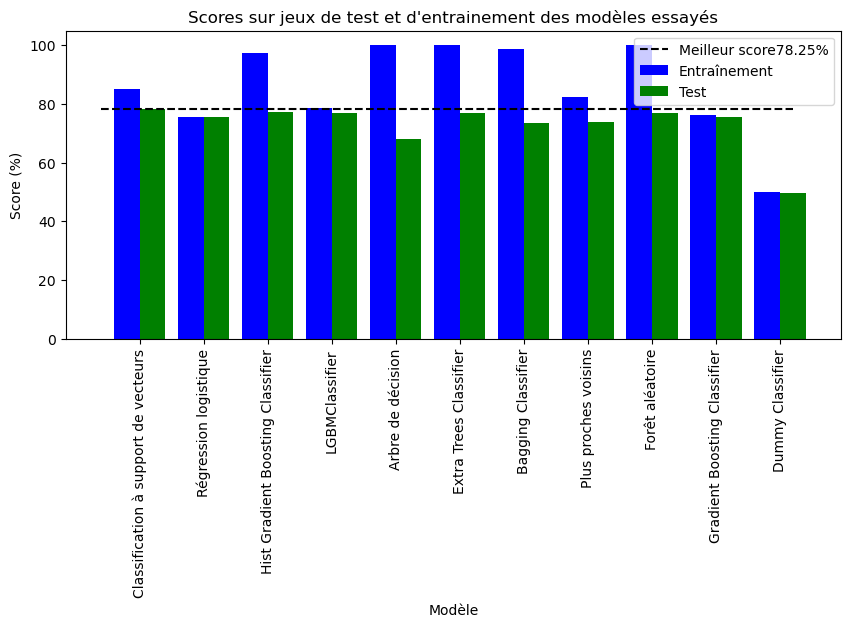

In [19]:
fig = plt.figure(figsize = (10, 4))

bar_width = 0.4
x_indexes = np.arange(tbl_perf.shape[0])
x_indexes_z = x_indexes + bar_width  # Décalage pour les barres de z

plt.bar(x_indexes, tbl_perf["score_ent"]*100., width=bar_width, color='blue', label='Entraînement')
plt.bar(x_indexes_z, tbl_perf["score_test"]*100., width=bar_width, color='green', label='Test')
meilleur_score = tbl_perf["score_test"].max()*100
plt.hlines(meilleur_score, x_indexes[0] - bar_width, x_indexes[-1] + bar_width,
           color='black', linestyles='dashed', label =f"Meilleur score{meilleur_score:3.2f}%")

plt.title("Scores sur jeux de test et d'entrainement des modèles essayés")
plt.xlabel("Modèle")
plt.ylabel("Score (%)")
plt.xticks(x_indexes + bar_width / 2, tbl_perf["libelle"], rotation = 90)
plt.legend()
plt.savefig(rep_fig+"scores_ML.svg")
plt.show()

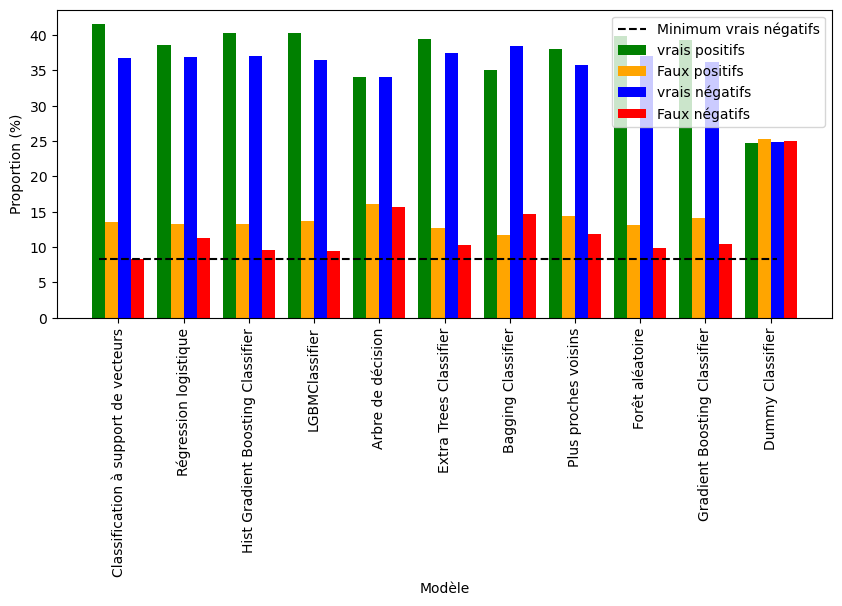

In [20]:
fig = plt.figure(figsize = (10, 4))

bar_width = 0.2
x1 = np.arange(tbl_perf.shape[0]) - bar_width
x2 = x1 + 1 * bar_width
x3 = x1 + 2 * bar_width
x4 = x1 + 3 * bar_width

plt.bar(x1, 100.*tbl_perf["tp"]/nb_test, width=bar_width,  color='green', label='vrais positifs')
plt.bar(x2, 100.*tbl_perf["fp"]/nb_test, width=bar_width, color='orange', label='Faux positifs')
plt.bar(x3, 100.*tbl_perf["tn"]/nb_test, width=bar_width, color='blue', label='vrais négatifs')
plt.bar(x4, 100.*tbl_perf["fn"]/nb_test, width=bar_width, color='red', label='Faux négatifs')

min_fn = 100.*tbl_perf.loc[tbl_perf["libelle"] != "Dummy Classifier", "fn"].min()/nb_test
plt.hlines(min_fn, x_indexes[0] - bar_width, x_indexes[-1] + bar_width,
           color='black', linestyles='dashed', label="Minimum vrais négatifs")
plt.title("")
plt.xlabel("Modèle")
plt.ylabel("Proportion (%)")
plt.xticks(x_indexes + bar_width / 2, tbl_perf["libelle"], rotation = 90)
plt.legend()
plt.savefig(rep_fig+"nbpred_ML.svg")

plt.show()

# Analyse avec SHAP

In [69]:


explainer = shap.Explainer(modeles["LGBM"]["model"], X_train)
shap_values = explainer.shap_values(X_test)


100%|===================| 35399/35529 [04:32<00:00]        

In [46]:
# Lecture de la description des variables, avec leurs libellés
with open(rep_ref + "/desc_vars.json", 'r', encoding='utf-8') as fichier:
    desc_vars = json.load(fichier)

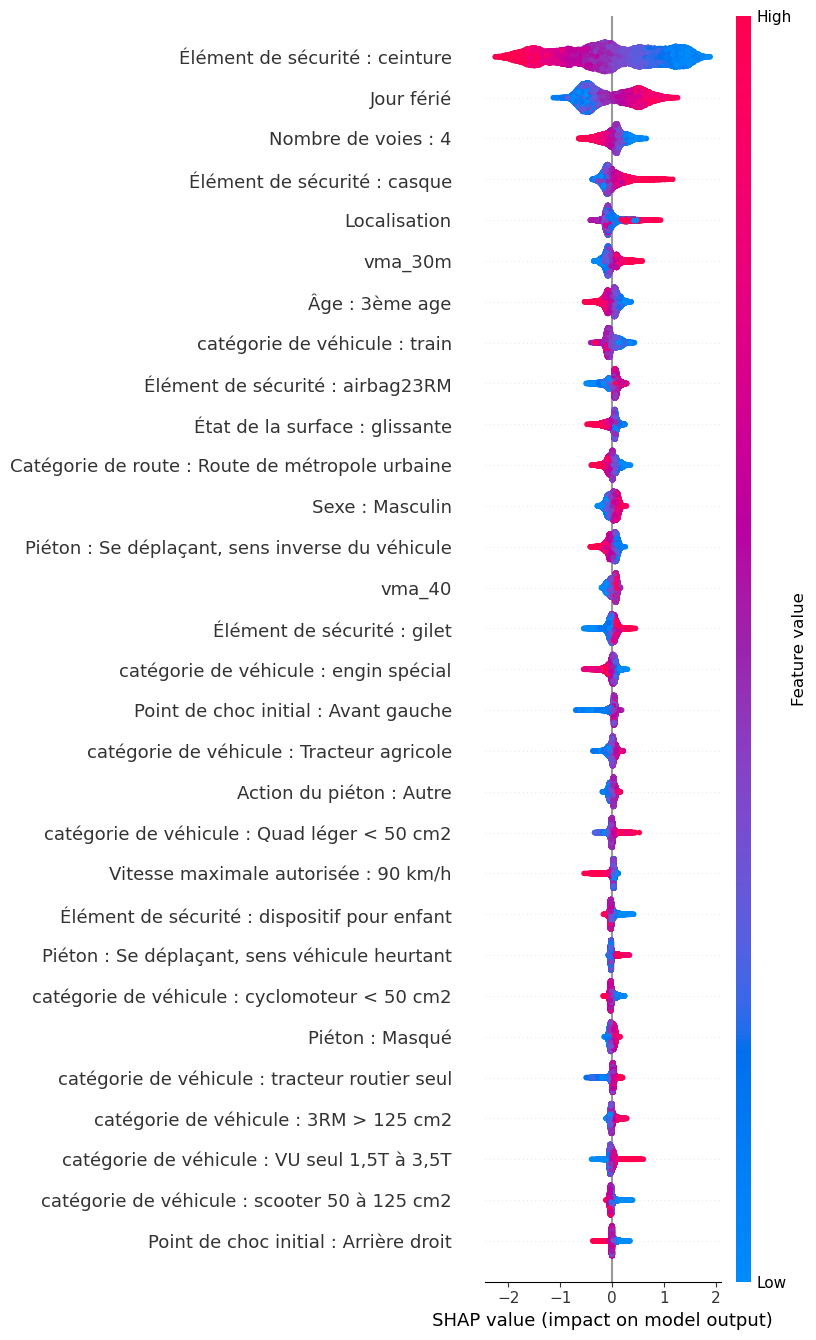

<Figure size 640x480 with 0 Axes>

In [65]:
# Pour afficher des labels explicites :
names = []
for idx in X.columns:
    try :
        name = desc_vars.get(idx).get("label")
    except Exception: 
        name = idx
    names.append(name)

fig = plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=names, max_display=30, show = False)
plt.savefig('shap_summary_plot.svg')
plt.close(fig)

plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=names, max_display=30)
plt.close()
plt.savefig(rep_fig+"nbpred_ML.svg")